# Cálculo de la frecuencia cardíaca a partir de los datos crudos del sensor

##  Preprocesamiento de los Datos

### Cargar los datos

In [73]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, find_peaks
import numpy as np

# 1. Cargar los datos
file_path = file_path = r"C:\Users\Elena\Desktop\GitHub\TFG-Elena-Ruiz\Datos\Datos crudos\save_log2\raw_data_92_76.csv"
data = pd.read_csv(file_path, sep=";")
data = data[data['Tiempo (ms)'] >= 5000]

# Opcional: Resetear el tiempo para que empiece en 0
data['Tiempo (ms)'] = data['Tiempo (ms)'] - 5000
tiempo = data['Tiempo (ms)']
IR = data['IR']
RED = data['RED']

IR_clean = IR - data['AMB_IR']
RED_clean = RED - data['AMB_RED']

IR_normalized = (IR_clean - IR_clean.mean()) / IR_clean.std()
RED_normalized = (RED_clean - RED_clean.mean()) / RED_clean.std()

In [74]:
from scipy.signal import butter, filtfilt

#Eliminar ruido de alta frecuencia con un filtro pasa bajos inicia

def lowpass_filter(signal, cutoff=5, fs=60, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, signal)

#Normalizar usando Z-Score adaptativo (reduce el impacto de outliers):

IR_lowpass = lowpass_filter(IR_clean)  # Aplicar antes de la normalización
RED_lowpass = lowpass_filter(RED_clean)

In [75]:
from scipy.signal import butter, filtfilt

def bandpass_filter(signal, fs=60, lowcut=0.5, highcut=3):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(2, [low, high], btype='band')
    filtered = filtfilt(b, a, signal)
    return filtered

IR_filtered = bandpass_filter(IR_normalized)

In [76]:
IR_normalized = (IR_lowpass - np.median(IR_lowpass)) / (np.quantile(IR_lowpass, 0.75) - np.quantile(IR_lowpass, 0.25))

In [77]:
from scipy.signal import welch

freqs, psd = welch(IR_filtered, fs=60, nperseg=512)
dominant_freq = freqs[np.argmax(psd)]
heart_rate_fft = dominant_freq * 60

In [78]:
heart_rates = []
for i in range(0, len(IR_filtered), 600):  # Ventanas de 10 segundos
    segment = IR_filtered[i:i+600]
    if len(segment) < 100: break
    freqs, psd = welch(segment, fs=60, nperseg=256)
    dominant_freq = freqs[np.argmax(psd)]
    heart_rates.append(dominant_freq * 60)
heart_rate_fft = np.median(heart_rates)

In [79]:
def adaptive_peak_detection(signal, min_distance=40, dynamic_threshold=True):
    peaks = []
    threshold = 0.5 * np.std(signal)
    for i in range(1, len(signal)-1):
        if dynamic_threshold:
            threshold = 0.5 * np.std(signal[max(0, i-100):i+100])
        if (signal[i] > signal[i-1] and 
            signal[i] > signal[i+1] and 
            signal[i] > threshold and 
            (len(peaks) == 0 or i - peaks[-1] > min_distance)):
            peaks.append(i)
    return np.array(peaks)

peaks = adaptive_peak_detection(IR_filtered)

In [84]:
if len(peaks) >= 2:
    intervals = np.diff(tiempo.iloc[peaks] / 1000)  # Convertir a segundos
    heart_rate_time = 60 / np.median(intervals)
else:
    heart_rate_time = None  # No hay suficientes picos
n_picos =np.median(intervals)

0.7159999999999984

In [81]:
if heart_rate_time is not None:
    final_hr = np.mean([heart_rate_fft, heart_rate_time])
else:
    final_hr = heart_rate_fft
print(f"Frecuencia cardíaca final: {final_hr:.1f} lpm")

Frecuencia cardíaca final: 84.1 lpm


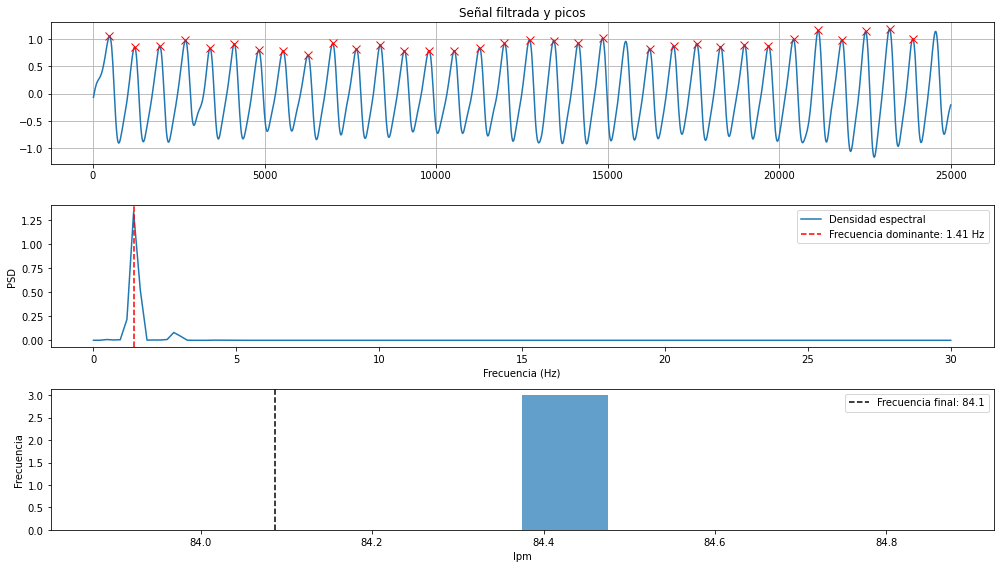

In [82]:
plt.figure(figsize=(14, 8))
plt.subplot(3, 1, 1)
plt.plot(tiempo, IR_filtered, label='IR filtrada')
plt.plot(tiempo.iloc[peaks], IR_filtered[peaks], 'rx', markersize=8, label='Picos detectados')
plt.title('Señal filtrada y picos')
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(freqs, psd, label='Densidad espectral')
plt.axvline(dominant_freq, color='r', linestyle='--', label=f'Frecuencia dominante: {dominant_freq:.2f} Hz')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('PSD')
plt.legend()

plt.subplot(3, 1, 3)
plt.hist(heart_rates, bins=10, alpha=0.7)
plt.axvline(final_hr, color='k', linestyle='--', label=f'Frecuencia final: {final_hr:.1f}')
plt.xlabel('lpm')
plt.ylabel('Frecuencia')
plt.legend()
plt.tight_layout()
plt.show()